In [30]:
import os
import numpy as np
import sklearn as sk
from sklearn.model_selection import train_test_split
import cv2

In [2]:
fp1 = r"C:\Users\Pier\Desktop\PFI_main\ds_mezcla_segmentacion integra\separadas2\sujetos"
fp2 = r"C:\Users\Pier\Desktop\PFI_main\ds_mezcla_segmentacion integra\separadas2\mascaras"
sujetos = os.listdir(fp1)
segmentaciones = os.listdir(fp2)

In [3]:
suj_train,suj_test,seg_train,seg_test = train_test_split(sujetos,segmentaciones,train_size=0.7,random_state=23)

In [ ]:
import shutil
fp1 = r"C:\Users\Pier\Desktop\PFI_main\ds_mezcla_segmentacion integra\separadas2\sujetos"
fp0 = r"C:\Users\Pier\Desktop\PFI_main\ds_mezcla_segmentacion integra\separadas2\mascaras"
fp2 = r"C:\Users\Pier\Desktop\PFI_main\ds_mezcla_segmentacion integra\separadas2\sujeto_train"
fp3 = r"C:\Users\Pier\Desktop\PFI_main\ds_mezcla_segmentacion integra\separadas2\sujeto_test"
fp4 = r"C:\Users\Pier\Desktop\PFI_main\ds_mezcla_segmentacion integra\separadas2\mascaras_train"
fp5 = r"C:\Users\Pier\Desktop\PFI_main\ds_mezcla_segmentacion integra\separadas2\mascaras_test"
for file in suj_train:
    shutil.move(os.path.join(fp1,file), os.path.join(fp2,file))
for file in suj_test:
    shutil.move(os.path.join(fp1,file), os.path.join(fp3,file))
for file in seg_train:
    shutil.move(os.path.join(fp0,file), os.path.join(fp4,file))
for file in seg_test:
    shutil.move(os.path.join(fp0,file), os.path.join(fp5,file))

In [31]:
import tensorflow as tf

is_gpu_available = (len(tf.config.list_physical_devices('GPU')) > 0)
print(is_gpu_available)

True


--- UNET ---


In [32]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from keras.optimizers import Adam
from keras.layers import Activation, MaxPool2D, Concatenate

In [33]:
def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)   #Not in the original network. 
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)  #Not in the original network
    x = Activation("relu")(x)

    return x

In [34]:
def encoder_block(input, num_filters):
    x = conv_block(input, num_filters)
    p = MaxPool2D((2, 2))(x)
    return x, p

In [35]:
def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

In [36]:
def build_unet(input_shape, n_classes):
    inputs = Input(input_shape)

    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    b1 = conv_block(p4, 1024) #Bridge

    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    if n_classes == 1:
      activation = 'sigmoid'
    else:
      activation = 'softmax'

    outputs = Conv2D(n_classes, 1, padding="same", activation=activation)(d4)  

    model = Model(inputs, outputs, name="U-Net")
    return model

In [37]:
my_unet = build_unet(input_shape=(384,384,1), n_classes=1)
print(my_unet.summary())

Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 384, 384, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_19 (Conv2D)             (None, 384, 384, 64  640         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_18 (BatchN  (None, 384, 384, 64  256        ['conv2d_19[0][0]']              
 ormalization)                  )                                                             

In [38]:
my_unet.compile(optimizer=Adam(learning_rate = 1e-3), loss='binary_crossentropy', metrics=['accuracy'])

In [39]:
fp1 = r"C:\Users\Pier\Desktop\PFI_main\ds_mezcla_segmentacion integra\separadas2\sujeto_train"
fp2 = r"C:\Users\Pier\Desktop\PFI_main\ds_mezcla_segmentacion integra\separadas2\mascaras_train"
sujetos = os.listdir(fp1)
segmentaciones = os.listdir(fp2)

In [40]:
sujetos = [os.path.join(fp1,suj) for suj in sujetos[0:200]]
images = [cv2.imread(img, 0) for img in sujetos]
sujeto_ds = np.array(images)
sujeto_ds = np.expand_dims(sujeto_ds, axis = 3)

In [41]:
mascaras = [os.path.join(fp2,mas) for mas in segmentaciones[0:200]]
images = [cv2.imread(img, 0) for img in mascaras]
seg_ds= np.array(images)
seg_ds = np.expand_dims(seg_ds, axis = 3) 

In [42]:
print("Image data shape is: ", sujeto_ds.shape)
print("Mask data shape is: ", seg_ds.shape)
print("Max pixel value in image is: ", sujeto_ds.max())
print("Labels in the mask are : ", np.unique(seg_ds))

Image data shape is:  (200, 384, 384, 1)
Mask data shape is:  (200, 384, 384, 1)
Max pixel value in image is:  255
Labels in the mask are :  [  0 255]


In [43]:
#Normalize images
image_dataset = sujeto_ds /255.  #Can also normalize or scale using MinMax scaler
#Do not normalize masks, just rescale to 0 to 1.
mask_dataset = seg_ds /255.  #PIxel values will be 0 or 1

In [44]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(image_dataset, mask_dataset, test_size = 0.20, random_state = 42)

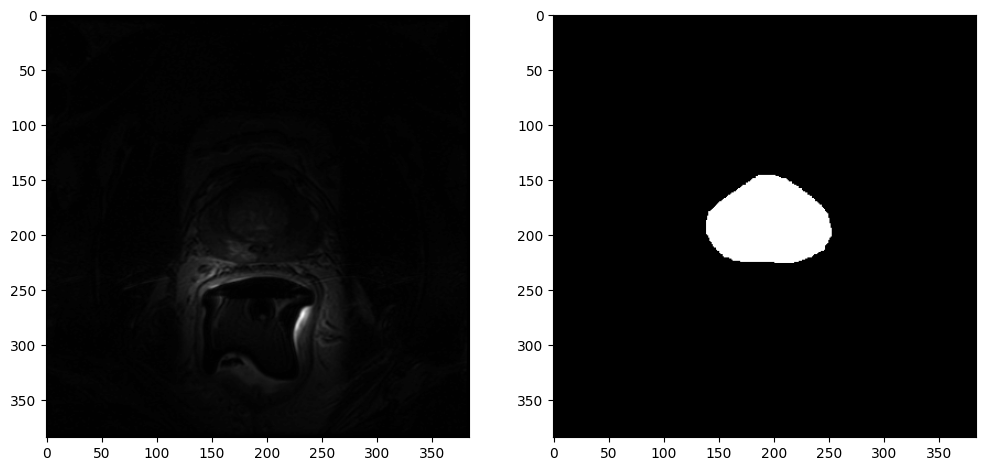

In [45]:
#Sanity check, view few mages
import random
import matplotlib.pyplot as plt

image_number = random.randint(0, len(X_train)-1)
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(X_train[image_number,:,:,0], cmap='gray')
plt.subplot(122)
plt.imshow(y_train[image_number,:,:,0], cmap='gray')
plt.show()

In [46]:
from tensorflow import keras

In [48]:
keras.backend.clear_session()

In [47]:
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10,restore_best_weights=True)

In [49]:
history = my_unet.fit(X_train, y_train, 
                    batch_size = 1, 
                    verbose=1, 
                    epochs=25, 
                    validation_data=(X_test, y_test), 
                    shuffle=False,
                    callbacks=[early_stopping_cb])

Epoch 1/25
160/160 [==============================] - 37s 220ms/step - loss: 0.1513 - accuracy: 0.9632 - val_loss: 0.1127 - val_accuracy: 0.9764
Epoch 2/25
160/160 [==============================] - 35s 217ms/step - loss: 0.0723 - accuracy: 0.9734 - val_loss: 0.1135 - val_accuracy: 0.9754
Epoch 3/25
160/160 [==============================] - 34s 214ms/step - loss: 0.0616 - accuracy: 0.9746 - val_loss: 0.0964 - val_accuracy: 0.9764
Epoch 4/25
160/160 [==============================] - 34s 214ms/step - loss: 0.0573 - accuracy: 0.9749 - val_loss: 0.0670 - val_accuracy: 0.9763
Epoch 5/25
160/160 [==============================] - 35s 217ms/step - loss: 0.0697 - accuracy: 0.9754 - val_loss: 2.8217 - val_accuracy: 0.1319
Epoch 6/25
160/160 [==============================] - 35s 219ms/step - loss: 0.0586 - accuracy: 0.9745 - val_loss: 0.0873 - val_accuracy: 0.9749
Epoch 7/25
160/160 [==============================] - 34s 214ms/step - loss: 0.0525 - accuracy: 0.9753 - val_loss: 0.0789 - val_ac

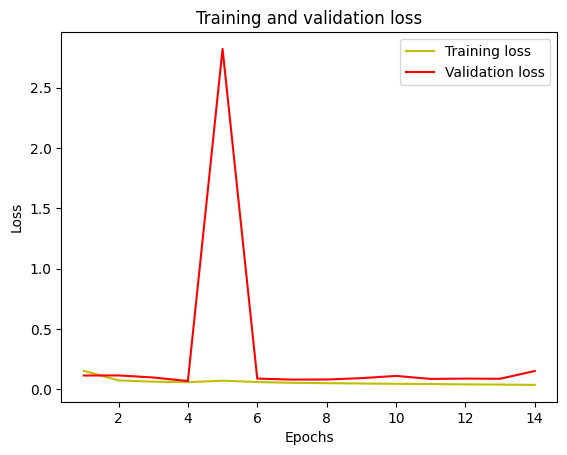

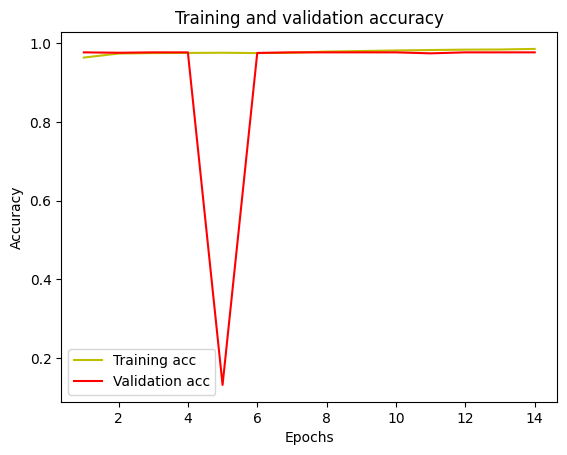

In [50]:
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [60]:
from keras.metrics import MeanIoU

y_pred=my_unet.predict(X_test[0:10])
y_pred_thresholded = y_pred > 0.5


1/1 [==============================] - 7s 7s/step


Mean IoU = 0.5171101
(1, 384, 384, 1)
1/1 [==============================] - 0s 18ms/step
(384, 384)


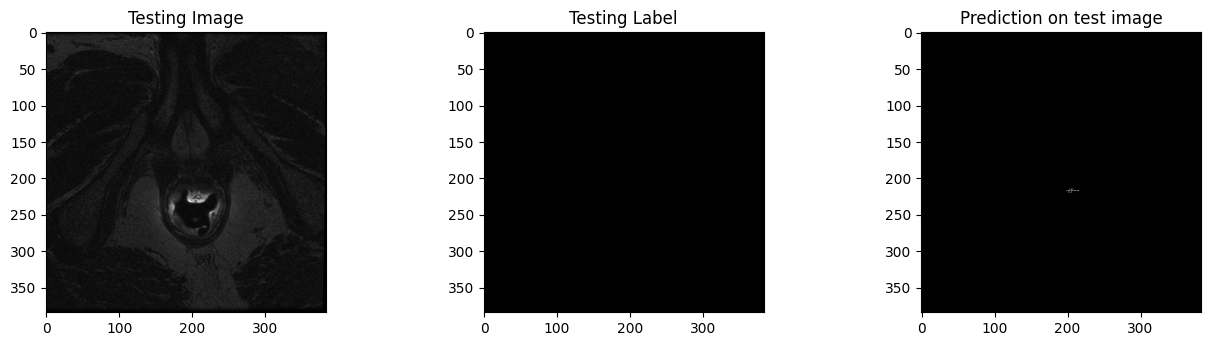

In [67]:

n_classes = 2
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(y_pred_thresholded, y_test[0:10])
print("Mean IoU =", IOU_keras.result().numpy())
threshold = 0.5
test_img_number = random.randint(0, len(X_test)-1)
test_img = X_test[test_img_number]
ground_truth=y_test[test_img_number]
test_img_input=np.expand_dims(test_img, 0)
print(test_img_input.shape)
prediction = (my_unet.predict(test_img_input)[0,:,:,0] > 0.5).astype(np.uint8)
print(prediction.shape)

plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='gray')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(prediction, cmap='gray')
plt.show()
